# Explore Training Curves

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (6,5)

In [2]:
def find_moving_avg(data, window_size):
    if data.shape[0] == 1:
        quantile1 = np.zeros(data.shape[1]-window_size)
        quantile2 = np.zeros(data.shape[1]-window_size)
        avg = np.zeros(data.shape[1]-window_size)
        for i in range(data.shape[1]-window_size):
            avg[i] = np.mean(data[0,i:i+window_size])
            quantile1[i] = np.quantile(data[0,i:i+window_size], 0.25)
            quantile2[i] = np.quantile(data[0,i:i+window_size], 0.75)
        return avg, quantile1, quantile2
    else:
        std = np.std(data,axis=0)
        avg = np.mean(data,axis=0)
        smoothed_avg = np.zeros(data.shape[1]-window_size)
        smoothed_std = np.zeros(data.shape[1]-window_size)
        # smooth 
        for i in range(data.shape[1]-window_size):
            smoothed_avg[i] = np.mean(avg[i:i+window_size])
            smoothed_std[i] = np.mean(std[i:i+window_size])
        return smoothed_avg, smoothed_avg-0.5*smoothed_std, smoothed_avg+0.5*smoothed_std
            

def df_plot(dfs, x, y, isYelloRoom, ylim=None, xlim=None, legend_loc='best'):
    """ Plot y vs. x curves from pandas dataframe(s)

    Args:
        dfs: list of pandas dataframes
        x: str column label for x variable
        y: str column label for y variable
        ylim: tuple to override automatic y-axis limits
        xlim: tuple to override automatic x-axis limits
        legend_loc: str to override automatic legend placement:
            'upper left', 'lower left', 'lower right' , 'right' ,
            'center left', 'center right', 'lower center',
            'upper center', and 'center'
    """
    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)
        
    n = len(dfs)
    ws = 5
    if isYelloRoom == True:
        min_len = 100
        y_val = np.zeros((n,100))
        plt.title('Move to Yellow Room', fontsize = 26)
    
    i = 0
    for df, name in dfs:
        if '_' in name:
            name = name.split('_')[1]
            if 'Human' in name:
                name = 'Human'
            else:
                name = 'ODRPO'
        x_val = df[x]
        y_val[i,:] = df[y].values.ravel()[0:min_len]
        i += 1
                
    moving_average = find_moving_avg(y_val, ws)
    if name == 'ODRPO':
        plt.plot(x_val[0:len(moving_average[0])], moving_average[0], linewidth = 2.5, label=name, color = 'tab:purple')
        plt.fill_between(x_val[0:len(moving_average[0])], moving_average[1], moving_average[2], alpha=0.3, color = 'tab:purple')
    if name == 'Human':
        plt.plot(x_val[0:len(moving_average[0])], moving_average[0], linewidth = 2.5, label=name, color = 'tab:orange')
        plt.fill_between(x_val[0:len(moving_average[0])], moving_average[1], moving_average[2], alpha=0.3, color = 'tab:orange')
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.axis((None,None,None,None))
    plt.xlabel('            Episodes       ', fontsize=22)
    plt.ylabel('Average Return',fontsize=22)

In [3]:
odrpo_path = ['log_files/GridWorld-v0_DR-KL_Batch=1/Jan-14_08:38:45/log.csv', 'log_files/GridWorld-v0_DR-KL_Batch=1/Jan-14_08:38:28/log.csv',
             'log_files/GridWorld-v0_DR-KL_Batch=1/Jan-14_11:10:37/log.csv', 'log_files/GridWorld-v0_DR-KL_Batch=1/Jan-14_11:28:45/log.csv',
             'log_files/GridWorld-v0_DR-KL_Batch=1/Jan-14_11:13:39/log.csv']
odrpo_human_path = ['log_files/GridWorld-v0_DR-KL-Human_Batch=1/Jan-14_09:22:51/log.csv', 'log_files/GridWorld-v0_DR-KL-Human_Batch=1/Jan-14_09:23:40/log.csv',
                    'log_files/GridWorld-v0_DR-KL-Human_Batch=1/Jan-14_11:14:38/log.csv', 'log_files/GridWorld-v0_DR-KL-Human_Batch=1/Jan-14_11:28:54/log.csv',
                    'log_files/GridWorld-v0_DR-KL-Human_Batch=1/Jan-14_11:08:51/log.csv']

odrpo_dataframes = []
odrpo_names = []
for filepath in odrpo_path:
    odrpo_names.append(filepath.split('/')[1])
    odrpo_dataframes.append(pd.read_csv(filepath))
odrpo_data = list(zip(odrpo_dataframes, odrpo_names))

odrpo_human_dataframes = []
odrpo_human_names = []
for filepath in odrpo_human_path:
    odrpo_human_names.append(filepath.split('/')[1])
    odrpo_human_dataframes.append(pd.read_csv(filepath))
odrpo_human_data = list(zip(odrpo_human_dataframes, odrpo_human_names))

# Plots

In [4]:
def find_baseline_moving_avg(file_list, window_size):  
    if len(file_list) == 1:
        df=pd.read_csv(file_list[0], sep=',', skiprows = 0, header= 1)
        data = df['r']
        quantile1 = np.zeros(len(data)-window_size)
        quantile2 = np.zeros(len(data)-window_size)
        avg = np.zeros(len(data)-window_size)
        for i in range(len(data)-window_size):
            avg[i] = np.mean(data[i:i+window_size])
            quantile1[i] = np.quantile(data[i:i+window_size], 0.25)
            quantile2[i] = np.quantile(data[i:i+window_size], 0.75)
        return avg, quantile1, quantile2
    else:
        # find minimum length
        min_len = 1e7
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep=',', skiprows = 0, header= 1)
            y_val = df['r']
            cur_len = len(y_val)
            if cur_len < min_len:
                min_len = cur_len
        data = np.zeros((len(file_list), min_len))
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep=',', skiprows = 0, header= 1)
            data[i,:] = df['r'].values.ravel()[0:min_len]
        std = np.std(data,axis=0)
        avg = np.mean(data,axis=0)
        smoothed_avg = np.zeros(min_len-window_size)
        smoothed_std = np.zeros(min_len-window_size)
        # smooth 
        for i in range(min_len-window_size):
            smoothed_avg[i] = np.mean(avg[i:i+window_size])
            smoothed_std[i] = np.mean(std[i:i+window_size])
        return smoothed_avg, smoothed_avg-smoothed_std, smoothed_avg+smoothed_std

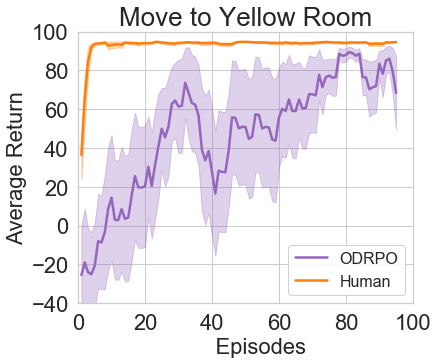

In [7]:
isYellowRoom = True

df_plot(odrpo_data, '_Episode', ['_AvgRewardSum'], isYellowRoom, [-40,100], [0,100])
df_plot(odrpo_human_data, '_Episode', ['_AvgRewardSum'], isYellowRoom, [-40,100], [0,100])

plt.rcParams["legend.framealpha"] = 0.9
plt.legend(fontsize=16, loc='lower right')

# Baseline 

In [8]:
def find_baseline_moving_avg(file_list, window_size):  
    if len(file_list) == 1:
        df=pd.read_csv(file_list[0], sep = ',', skiprows = 0, header = 0)
        data = df['r']
        quantile1 = np.zeros(len(data)-window_size)
        quantile2 = np.zeros(len(data)-window_size)
        avg = np.zeros(len(data)-window_size)
        for i in range(len(data)-window_size):
            avg[i] = np.mean(data[i:i+window_size])
            quantile1[i] = np.quantile(data[i:i+window_size], 0.25)
            quantile2[i] = np.quantile(data[i:i+window_size], 0.75)
        return avg, quantile1, quantile2
    else:
        # find minimum length
        min_len = 1e7
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep = ',', skiprows = 0, header = 0)
            y_val = df['r']
            cur_len = len(y_val)
            if cur_len < min_len:
                min_len = cur_len
        data = np.zeros((len(file_list), min_len))
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep = ',', skiprows = 0, header = 0)
            data[i,:] = df['r'].values.ravel()[0:min_len]
        std = np.std(data,axis=0)
        avg = np.mean(data,axis=0)
        smoothed_avg = np.zeros(min_len-window_size)
        smoothed_std = np.zeros(min_len-window_size)
        # smooth 
        for i in range(min_len-window_size):
            smoothed_avg[i] = np.mean(avg[i:i+window_size])
            smoothed_std[i] = np.mean(std[i:i+window_size])
        return smoothed_avg, smoothed_avg-smoothed_std, smoothed_avg+smoothed_std

(0, 100)

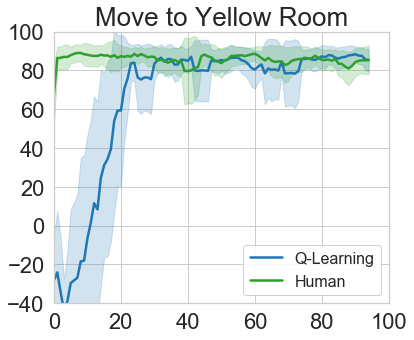

In [9]:
q_learning_log_name = ['./log_files/GridWorld-q-learning/1610621904.212886.csv', './log_files/GridWorld-q-learning/1610621963.719276.csv', 
                       './log_files/GridWorld-q-learning/1610622971.841064.csv', './log_files/GridWorld-q-learning/1610623929.645105.csv',
                       './log_files/GridWorld-q-learning/1610624213.111349.csv']
q_learning_human_log_name = ['./log_files/GridWorld-q-learning-human/1610621943.9203851.csv', './log_files/GridWorld-q-learning-human/1610621957.896211.csv',
                             './log_files/GridWorld-q-learning-human/1610622976.264647.csv', './log_files/GridWorld-q-learning-human/1610623933.438024.csv',
                             './log_files/GridWorld-q-learning-human/1610624216.214272.csv']

window_size = 5
moving_average = find_baseline_moving_avg(q_learning_log_name, window_size)
plt.plot(np.arange(len(moving_average[0])), moving_average[0], label='Q-Learning', linewidth = 2.5, color = 'tab:blue')
plt.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2, color = 'tab:blue')

moving_average = find_baseline_moving_avg(q_learning_human_log_name, window_size)
plt.plot(np.arange(len(moving_average[0])), moving_average[0], label='Human', linewidth = 2.5, color = 'tab:green')
plt.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2, color = 'tab:green')

plt.title('Move to Yellow Room', fontsize = 26)
plt.rcParams["legend.framealpha"] = 0.9
plt.legend(fontsize=16, loc='lower right')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim([-40, 100])
plt.xlim([0, 100])